# Loan Approval Prediction Using Neural Networks
### Name: Atharva Kahu
### NetID: axk220142

In [1]:
#!pip install keras-tuner

In [3]:
# Importing all required libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras_tuner.tuners import Hyperband
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [4]:
#loading the Loan Approval Dataset
df = pd.read_csv("loan_data.csv")

In [5]:
#One Hot Encoding For Non Ordinal Features
df = pd.get_dummies(df, columns=['person_gender', 'person_home_ownership', 'loan_intent', 'previous_loan_defaults_on_file'])

In [6]:
#Label Encoding Ordinal Features
education_order = ['High School', 'Associate', 'Bachelor', 'Master', 'Doctorate']

education_mapping = {level: idx for idx, level in enumerate(education_order)}
df['person_education'] = df['person_education'].map(education_mapping)

In [7]:
df.head(5)

,person_age,person_education,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,loan_status,...,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,previous_loan_defaults_on_file_No,previous_loan_defaults_on_file_Yes
0,22.0,3,71948.0,0,35000.0,16.02,0.49,3.0,561,1,...,False,True,False,False,False,False,True,False,True,False
1,21.0,0,12282.0,0,1000.0,11.14,0.08,2.0,504,0,...,True,False,False,True,False,False,False,False,False,True
2,25.0,0,12438.0,3,5500.0,12.87,0.44,3.0,635,1,...,False,False,False,False,False,True,False,False,True,False
3,23.0,2,79753.0,0,35000.0,15.23,0.44,2.0,675,1,...,False,True,False,False,False,True,False,False,True,False
4,24.0,3,66135.0,1,35000.0,14.27,0.53,4.0,586,1,...,False,True,False,False,False,True,False,False,True,False


In [8]:
X = df.drop(columns=['loan_status'])  # Drop target column if present
y = df['loan_status']

In [9]:
#Train, Test & Validation dataset split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=0,stratify=df['loan_status'])
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=0)

In [10]:
# Applying Standard Scalar to the dataset
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)
X_test = sc.transform(X_test)

## 1.  Model_1: Building a simple model (without Hyperparameter tuning)

In [12]:
#Defining is simple Neural Network with two layers 
model_1 = tf.keras.models.Sequential()
model_1.add(tf.keras.layers.Input(shape=(X_train.shape[1],)))
model_1.add(tf.keras.layers.Dense(units=16, activation='relu'))
model_1.add(tf.keras.layers.Dense(units=16, activation='relu'))
model_1.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [13]:
# early stopping to halt training when validation loss stops improving for 3 epochs, restoring the best model weights
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    min_delta=0.0001,
    restore_best_weights=True
)

In [14]:
#Train the model on training data with validation monitoring
history = model_1.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=50,  # Set to a higher number since early stopping may halt training early
    callbacks=[early_stopping]
)

Epoch 1/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8273 - loss: 0.3613 - val_accuracy: 0.8969 - val_loss: 0.2278
Epoch 2/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9003 - loss: 0.2183 - val_accuracy: 0.8976 - val_loss: 0.2192
Epoch 3/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9051 - loss: 0.2131 - val_accuracy: 0.9052 - val_loss: 0.2125
Epoch 4/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9043 - loss: 0.2089 - val_accuracy: 0.9051 - val_loss: 0.2088
Epoch 5/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9073 - loss: 0.2037 - val_accuracy: 0.9074 - val_loss: 0.2046
Epoch 6/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9094 - loss: 0.1977 - val_accuracy: 0.9082 - val_loss: 0.2010
Epoch 7/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9078 - loss: 0.1991 - val_accuracy: 0.9109 - val_loss: 0.1998
Epoch 8/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9092 - loss: 0.1989 - val_accuracy: 0.

In [15]:
test_loss, test_accuracy = model_1.evaluate(X_test, y_test, verbose=0)

In [16]:
# Check if early stopping was triggered
if early_stopping.stopped_epoch > 0:
    best_epoch = early_stopping.stopped_epoch - early_stopping.patience
else:
    best_epoch = len(history.history['accuracy']) - 1  # Use the last epoch as the best one

# Print the metrics
print('Training Loss', history.history['loss'][best_epoch])
print('Validation Loss', history.history['val_loss'][best_epoch])
print('Training Accuracy', history.history['accuracy'][best_epoch])
print('Validation Accuracy', history.history['val_accuracy'][best_epoch])
print('Test Accuracy', test_accuracy)
print('Epoch Stopped', best_epoch + 1)


Training Loss 0.17896875739097595
Validation Loss 0.18098245561122894
Training Accuracy 0.9195185303688049
Validation Accuracy 0.9184444546699524
Test Accuracy 0.9198889136314392
Epoch Stopped 20


In [27]:
model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 16)                  │             384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,021 (7.90 KB)

 Trainable params: 673 (2.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,348 (5.27 KB)

282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


<Figure size 600x600 with 0 Axes>

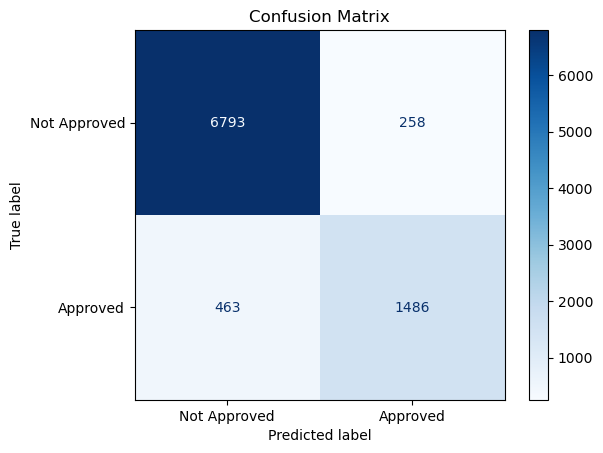

In [28]:


# Predict probabilities and convert them to binary (0 or 1)
y_pred_probs = model_1.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype("int32")

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Approved", "Approved"])

# Plot
plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()


In [29]:
report = classification_report(y_test, y_pred, target_names=["Not Default", "Default"])
print("Classification Report:\n")
print(report)

Classification Report:

              precision    recall  f1-score   support

 Not Default       0.94      0.96      0.95      7051
     Default       0.85      0.76      0.80      1949

    accuracy                           0.92      9000
   macro avg       0.89      0.86      0.88      9000
weighted avg       0.92      0.92      0.92      9000



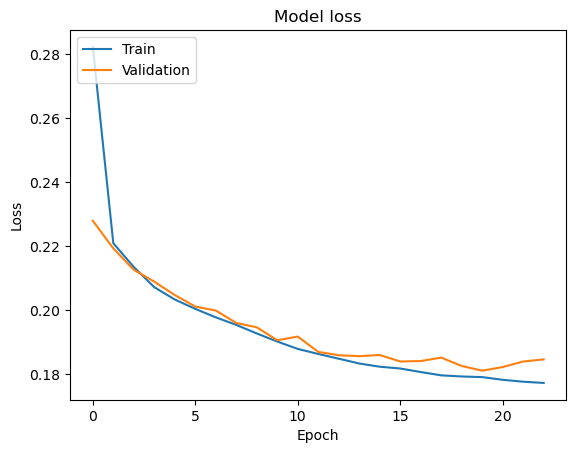

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


## 2. Model_2: Adding Hyper parameter tuning to the model

In [38]:
def model_2(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units_0', min_value=32, max_value=128, step=32),
                    activation=hp.Choice('activation_0', values=['relu', 'tanh', 'sigmoid']),
                    input_shape=(X_train.shape[1],)))
    model.add(Dense(units=hp.Int('units_1', min_value=32, max_value=128, step=32),
                    activation=hp.Choice('activation_1', values=['relu', 'tanh', 'sigmoid'])))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [40]:
tuner = Hyperband(
    model_2,
    objective='val_loss',
    max_epochs=20,
    factor=3,
    directory='hyperband_dir',
    project_name='loan_default_tuning',
    overwrite=True
)


In [42]:
start_time = time.time()
tuner.search(X_train, y_train, validation_data=(X_val, y_val), epochs=20,callbacks=[early_stopping], verbose=1)
search_duration = time.time() - start_time

Trial 30 Complete [00h 00m 12s]
val_loss: 0.2151975780725479

Best val_loss So Far: 0.1764928549528122
Total elapsed time: 00h 06m 21s


In [43]:
best_model = tuner.get_best_models(num_models=1)[0]

In [44]:
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9225 - loss: 0.1770


In [45]:
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │           1,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 96)                  │           6,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              97 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,873 (30.75 KB)

 Trainable params: 7,873 (30.75 KB)

 Non-trainable params: 0 (0.00 B)

In [46]:
print(f"\nBest Hyperparameters: {best_hyperparameters.values}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Search Duration: {search_duration:.2f} seconds")



Best Hyperparameters: {'units_0': 64, 'activation_0': 'sigmoid', 'units_1': 96, 'activation_1': 'relu', 'learning_rate': 0.01, 'tuner/epochs': 20, 'tuner/initial_epoch': 7, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0014'}
Test Loss: 0.1761
Test Accuracy: 0.9222
Search Duration: 380.80 seconds


282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


<Figure size 600x600 with 0 Axes>

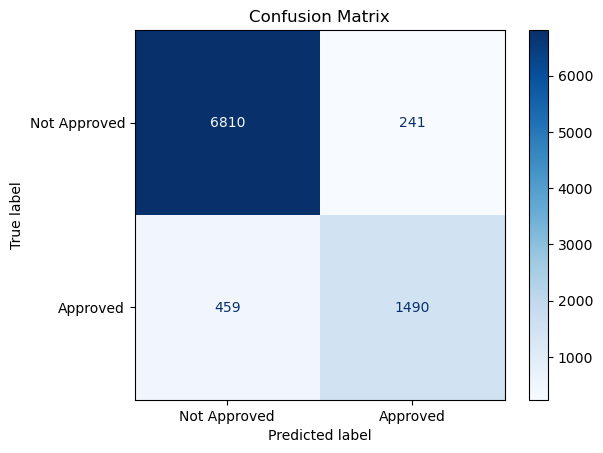

In [47]:
y_pred_probs = best_model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype("int32")

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Approved", "Approved"])

# Plot
plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

In [48]:
report = classification_report(y_test, y_pred, target_names=["Not Approved", "Approved"])
print("Classification Report:\n")
print(report)

Classification Report:

              precision    recall  f1-score   support

Not Approved       0.94      0.97      0.95      7051
    Approved       0.86      0.76      0.81      1949

    accuracy                           0.92      9000
   macro avg       0.90      0.87      0.88      9000
weighted avg       0.92      0.92      0.92      9000

